<a href="https://colab.research.google.com/github/geoffgeorgein/Tensorflow/blob/master/Weed2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from tqdm import tqdm
from random import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split  
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers


IMAGE_SIZE= 200
species = ['weed','crop']

data_dir = '/content/sample_data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
train_data = []
999
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['train/{}/{}'.format(sp, file), species_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'SpeciesId','Species'])
train.head()
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()
test_data = []
for file in os.listdir(test_dir):
    test_data.append(['test/{}'.format(file), file])
test = pd.DataFrame(test_data, columns=['Filepath', 'File'])
test.head()
#IMAGE_SIZE = 200

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size

try:
  def resize_image(image, image_size):
      return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)


except:
    pass

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))


for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    #image_segmented = segment_image(image)
    X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_train = X_train / 255.
print('Train Shape: {}'.format(X_train.shape))
Y_train = train['SpeciesId'].values
Y_train = to_categorical(Y_train, num_classes=2)
BATCH_SIZE = 5
EPOCHS = 12

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.4, random_state=SEED)

annealer = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
def construct_model():
	model = Sequential()

	model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
		        activation='relu'))
	model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch
	model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
	#model.add(BatchNormalization())
	model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

	model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
	model.add(BatchNormalization())
	model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
	#model.add(BatchNormalization())
	model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

	model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
	model.add(BatchNormalization())
	model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
	#model.add(BatchNormalization())
	model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

	model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
	model.add(BatchNormalization())
	model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
	#model.add(BatchNormalization())
	model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

	model.add(Flatten()) # Flatten the input
	model.add(Dense(256, activation='relu'))
	model.add(Dense(2, activation='softmax', 	kernel_regularizer=regularizers.l2(0.01)))
	# Configure the learning process
	# The loss function is the objective that the model will try to minimize
	# For any classification problem, use accuracy metric
	optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

	model.summary()
	
	return model
model = construct_model()
print(model) 
model.fit(X_train, Y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1,callbacks=[annealer], validation_data=(X_val, Y_val))
final_loss, final_accuracy = model.evaluate(X_val, Y_val, verbose=0)

print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy)) 
model.save('potmodel.h5')



'''
model=load_model('newmodel.h5')
img = cv2.imread("./test/weed (1).jpg")
img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
img = img.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)
print(model.predict([img])[0])


Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))

ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=species, yticklabels=species)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.show()'''



1464it [00:06, 215.41it/s]


Train Shape: (1464, 200, 200, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_1 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/16
176/176 [==============================] - 26s 86ms/step - loss: 0.4117 - accuracy: 0.8474 - val_loss: 0.7927 - val_accuracy: 0.4300 - lr: 1.0000e-04
Epoch 2/16
176/176 [==============================] - 13s 74ms/step - loss: 0.1514 - accuracy: 0.9624 - val_loss: 1.7007 - val_accuracy: 0.4300 - lr: 1.0000e-04
Epoch 3/16
176/176 [==============================] - 13s 76ms/step - loss: 0.1055 - accuracy: 0.9749 - val_loss: 1.1690 - val_accuracy: 0.4949 - lr: 1.0000e-04
Epoch 4/16
176/176 [==============================] - 14s 77ms/step - loss: 0.1054 - accuracy: 0.9784 - val_loss: 0.0630 - val_accuracy: 0.9949 - lr: 1.0000e-04
Epoch 5/16
176/176 [==============================] - 14s 80ms/step - loss: 0.0903 - accuracy: 0.9863 - val_loss: 0.0815 - val_accuracy: 0.9846 - lr: 1.0000e-04
Epoch 6/16
176/176 [==============================] - 13s 76ms/step - loss: 0.0655 - accuracy: 0.9954 - val_loss: 0.0542 - val_accuracy: 0.9983 - lr: 1.0000e-04
Epoch 7/16
176/176 [==============

'\nmodel=load_model(\'newmodel.h5\')\nimg = cv2.imread("./test/weed (1).jpg")\nimg = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))\nimg = img.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)\nprint(model.predict([img])[0])\n\n\nY_pred = model.predict(X_val)\n\nY_pred = np.argmax(Y_pred, axis=1)\nY_true = np.argmax(Y_val, axis=1)\n\ncm = confusion_matrix(Y_true, Y_pred)\nplt.figure(figsize=(12, 12))\n\nax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=species, yticklabels=species)\nax.set_ylabel(\'Actual\', fontsize=40)\nax.set_xlabel(\'Predicted\', fontsize=40)\nplt.show()'

[1. 0.]


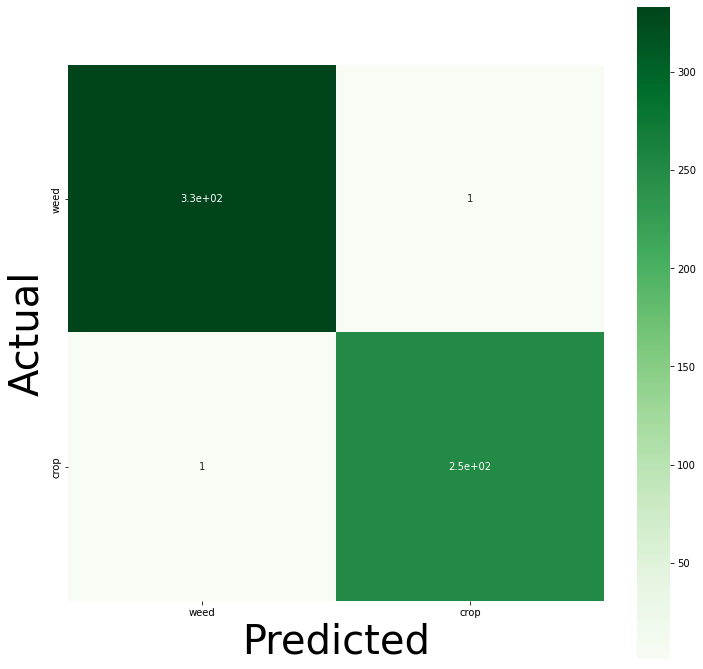

NameError: ignored

In [8]:
model=load_model('potmodel.h5')
img = cv2.imread("/content/sample_data/test/001_image.png")
img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
img = img.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)
print(model.predict([img])[0])


Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))

ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=species, yticklabels=species)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.show()

history.history['accuracy']